We will cyclically do preprocessing and EDA. In other words, we will first do some basic preprocessing and then some basic EDA. This basic EDA will tell us which further preprocessing steps need to be done. We will keep doing this till we process the data and it is ready for model building.

In [1]:
# Imports

import nltk

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

In [2]:
# Paths

REDDIT_DATA_PATH = "../data/raw/Reddit_Data.csv"
# TWITTER_DATA_PATH = "../data/raw/Twitter_Data.csv"
# YOUTUBE_DATA_PATH = "../data/raw/YoutubeCommentsDataSet.csv"

# Reading the data

In [3]:
df = pd.read_csv(REDDIT_DATA_PATH)
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
df.shape

(37249, 2)

The raw data has 37,249 rows, and 2 columns. A `category` value of `-1` indicates a negative comment, `0` indicates a neutral comment, and `1` indicates a positive comment.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_comment  37149 non-null  object
 1   category       37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


Looks like there are some missing comments.

In [6]:
df.sample().values

array([['because has strong team his behest they wouldn let people have hint about what going this country while the media doing yogi yogi and modi modi somewhere somebody getting lynched for taking milch cow his home have you heard about jharkhand lynching tvs jsp\nnope right when the leaders choose make themselves bidders auction popularity their talents the construction the state will service they will become flatterers instead legislators the instruments not the guides the people edmund burke\n',
        1]], dtype=object)

# Checking missing values

In [7]:
df.isnull().sum()

clean_comment    100
category           0
dtype: int64

There are 100 missing comments. Let us check the `category` value corresponding to these misisng comments.

In [8]:
df[df["clean_comment"].isna()]

,clean_comment,category
413,NaN,0
605,NaN,0
2422,NaN,0
2877,NaN,0
3307,NaN,0
...,...,...
35975,NaN,0
36036,NaN,0
37043,NaN,0
37111,NaN,0


In [9]:
df[df["clean_comment"].isna()]["category"].value_counts()

category
0    100
Name: count, dtype: int64

So, all the missing comments are categorized as being neutral. As 100 is insignificant as compared to 37,249, we can simply drop these missing values.

In [10]:
df.dropna(inplace=True, ignore_index=True)
df.isnull().sum()

clean_comment    0
category         0
dtype: int64

# Checking for duplicates

In [11]:
df.duplicated().sum()

350

In [12]:
df[df.duplicated()]

,clean_comment,category
375,,0
392,,0
615,aurum mom,0
649,,0
1220,,0
...,...,...
36818,who won,0
36946,,0
37026,hari,0
37059,top kek,1


There are just 350 duplicate rows. We can simply drop these.

In [13]:
df.drop_duplicates(inplace=True, ignore_index=True)
df.duplicated().sum()

0

We can observe that for some rows there are no comments. In other words, some rows in the `clean_comment` column look empty. They may be consisting of white spaces or other characters.

In [14]:
df[(df["clean_comment"].str.strip() == "")]

,clean_comment,category
181,,0
4392,\n,0
10523,,0
16025,,0
31785,\n,0
34545,,0


Let us remove these rows.

In [15]:
df = df[~(df["clean_comment"].str.strip() == "")].reset_index(drop=True)
df[(df["clean_comment"].str.strip() == "")]

,clean_comment,category


# Converting entries to lowercase

In [16]:
df["clean_comment"] = df["clean_comment"].str.lower()
df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


# Removing whitespaces

It looks like a lot of comments have trailing and leading white spaces.

In [17]:
df[df["clean_comment"].apply(lambda x: x.endswith(" ") or x.startswith(" "))]

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
36785,let the janta decide not ulema clerics,0
36786,hona hai same with vaccination education insu...,0
36790,downvote karna tha par upvote hogaya,0
36791,haha nice,1


A massive proportion of rows have this problem. Let us fix it.

In [18]:
df["clean_comment"] = df["clean_comment"].str.strip()
df[df["clean_comment"].apply(lambda x: x.endswith(" ") or x.startswith(" "))]

,clean_comment,category


# Identifying comments with URLs

URLs are not helpful in doing sentiment analysis. So, we will remove those.

In [19]:
URL_PATTERN = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
comments_with_urls = df[df["clean_comment"].str.contains(URL_PATTERN, regex=True)]

comments_with_urls.head()

,clean_comment,category


Fortunately, there are no comments with URLs in them.

# Identifying comments with newline and tab characters

In [20]:
df[df["clean_comment"].str.contains("\n")]

,clean_comment,category
444,what missing jpg\nand why this brilliant edit ...,1
774,india has been ruined congress and populist sc...,-1
840,like aap for its stand corruption and making p...,-1
864,reduced trade\ndeficit stronger rupee aren the...,0
1346,amsa press conference australian maritime safe...,1
...,...,...
34706,火箭o辛基 2016 sughosh bansal mission “make india”...,-1
34808,yikes the title should blind bhakts modi hater...,1
35750,hahahahahhahahah \niska klpd hogya,0
36078,्ा् ी ाी े ो ेी ाी े।\nे ी,0


In [21]:
df[df["clean_comment"].str.contains("\t")]

,clean_comment,category
480,183\tkazari uiharu\traildex 177\truiko saten\t...,1
5218,toi links posted\t5519 lol such fierce love ha...,1
13691,swavalamban yojana\t2010\tatal pension yojana ...,1
20534,nolanfan2 here some stuff shame chaudhary lal ...,1
25395,party won\tleading\ttotal\nbahujan samaj party...,1


Let us replace both these characters with a single whitespace.

In [22]:
df["clean_comment"] = df["clean_comment"].str.replace("\n", " ", regex=True)
df["clean_comment"] = df["clean_comment"].str.replace("\t", " ", regex=True)

In [23]:
df[df["clean_comment"].str.contains("\n")]

,clean_comment,category


In [24]:
df[df["clean_comment"].str.contains("\t")]

,clean_comment,category


# Visualizing class imbalance

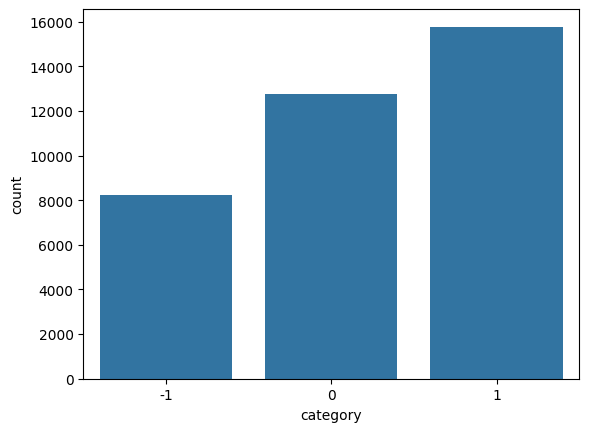

In [25]:
sns.countplot(data=df, x="category")
plt.show();

In [26]:
df["category"].value_counts(normalize=True).round(2)

category
 1    0.43
 0    0.35
-1    0.22
Name: proportion, dtype: float64

Most comments are positive (43%), followed by neutral (35%), and then negative (22%). We will have to deal with this imbalance.

# Creating a new column `word_count`

In [27]:
df["word_count"] = df["clean_comment"].apply(lambda x: len(x.split()))
df.sample(5)

,clean_comment,category,word_count
5643,for them its probably just regular day for was...,1,21
7089,have been planning say almost the exact same p...,1,19
16386,ultra realistic nanamo looks creepy least fits...,-1,9
9063,having such debate reddit freaking useless lef...,-1,41
5789,willing believe this guy but where the hard da...,-1,27


Let us now see if the sentiment of a comment has anything to do with how many words it has.

In [28]:
df["word_count"].describe()

count    36793.000000
mean        29.667464
std         56.790738
min          1.000000
25%          6.000000
50%         13.000000
75%         30.000000
max       1307.000000
Name: word_count, dtype: float64

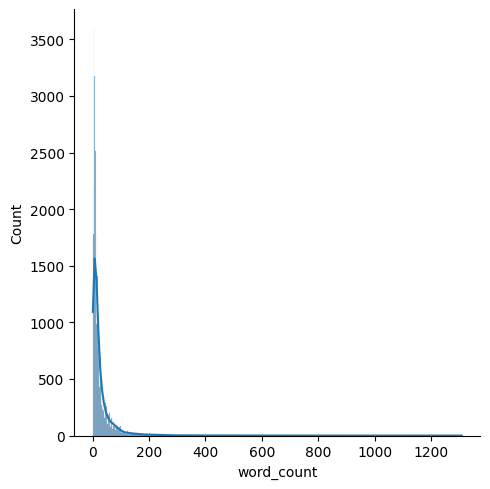

In [29]:
sns.displot(df["word_count"], kde=True)
plt.show();

Clearly, this column has a huge right skew. The overwhelming majority of comments have very few words, but there is a small proportion of comments with a huge amount of words. So there is a huge variation, which is also indicated by the standard deviation.

# `word_count` distribution by `category`

Let us now visualize the distribution of `word_count` for each `category`.

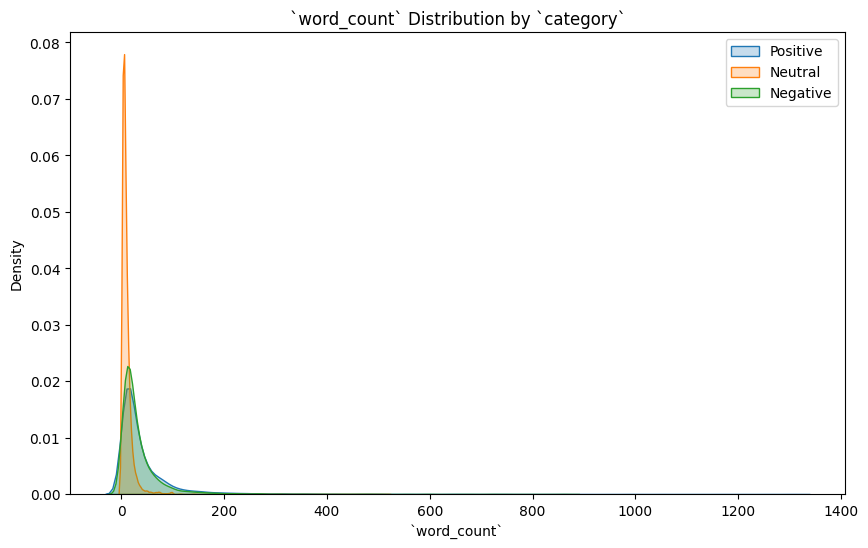

In [30]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df["category"] == 1]["word_count"], label="Positive", fill=True)
sns.kdeplot(df[df["category"] == 0]["word_count"], label="Neutral", fill=True)
sns.kdeplot(df[df["category"] == -1]["word_count"], label="Negative", fill=True)

plt.title("`word_count` Distribution by `category`")
plt.xlabel("`word_count`")
plt.ylabel("Density")
plt.legend()
plt.show();

* **Neutral comments:** These comments seem to have very few words and their distribution is largely concentrated around shorter comments.

* **Positive comments:** The word count of these comments have a wider spread, indicating that longer comments are more common in comments with a positive sentiment.

* **Negative comments:** These comments have a distribution similar to positive comments.

# Box plot of `word_count`

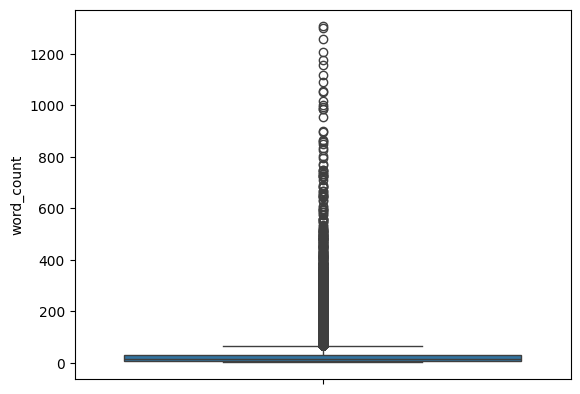

In [31]:
sns.boxplot(df["word_count"])
plt.show();

As expected, `word_count` has a lot of outliers. This was also clear when we found that this column has a huge right skew.

# Box plot of `word_count` by `category`

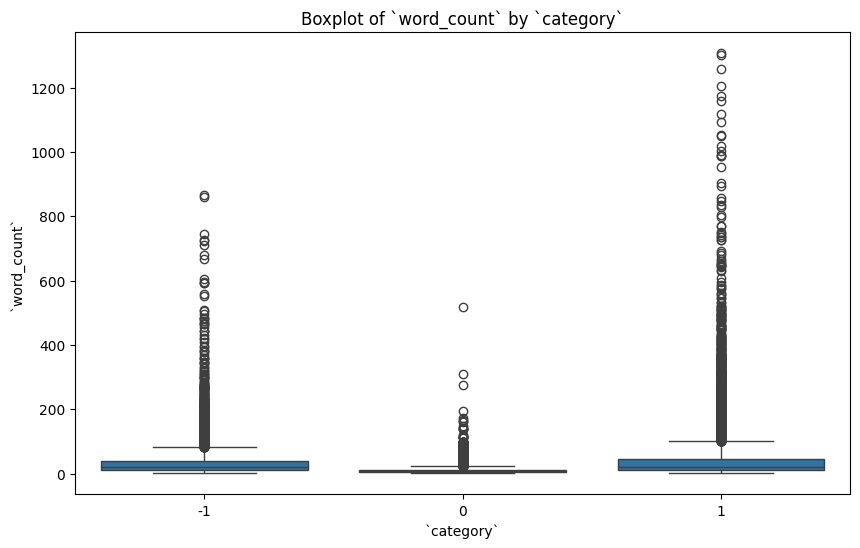

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="category", y="word_count")
plt.title("Boxplot of `word_count` by `category`")
plt.xlabel("`category`")
plt.ylabel("`word_count`")
plt.show();

Positive and negative comments have more outliers as compared to neutral comments. This was also clear when we saw the plot for `word_count` distribution by `category`. Some more observations are the following:

* **Neutral comments:** The median `word_count` for these comments is the lowest, with a tighter IQR. This suggests that neutral comments are generally shorter.
* **Positive comments:** The median `word_count` for these comments is relatively high, and there are several outliers with longer comments. This indicates that positive comments tend to be more verbose.
* **Negative comments:** The `word_count` distribution of these comments is similar to the positive comments, but with a slightly lower median and fewer extreme outliers.

# Scatter plot of `word_count` by `category`

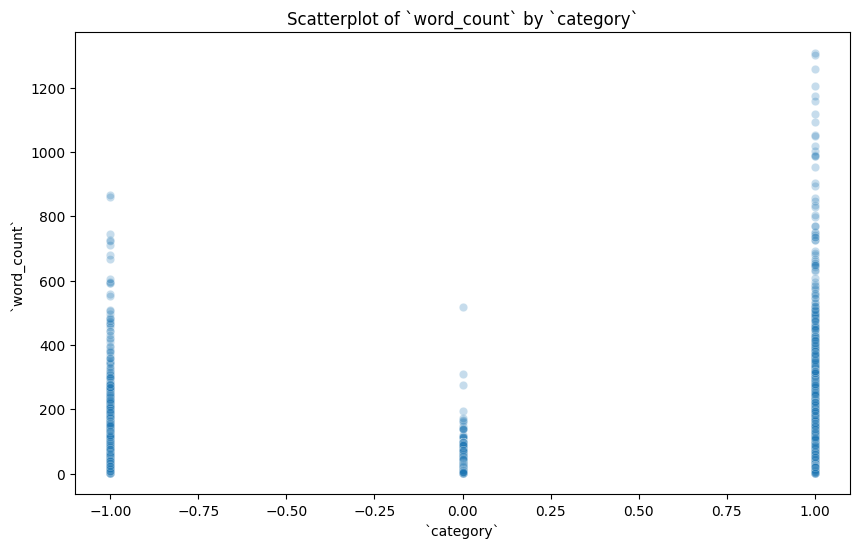

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="category", y="word_count", alpha=0.25)
plt.title("Scatterplot of `word_count` by `category`")
plt.xlabel("`category`")
plt.ylabel("`word_count`")
plt.show();

So, it looks like `word_count` can separate neutral comments from the positive and negative ones.

# Bar plot of the median `word_count` by `category`

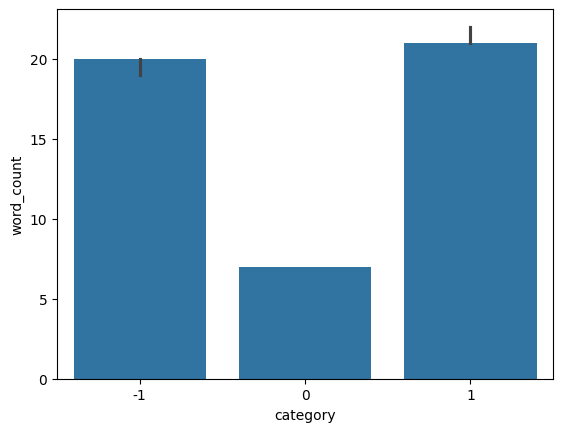

In [34]:
sns.barplot(df, x="category", y="word_count", estimator="median")
plt.show();

Again, the bar plot corroborates the fact that the distribution of neutral comments is different as compared to positive and negative comments.

# Number of stopwords

In [35]:
stop_words = set(stopwords.words("english"))
df["num_of_stop_words"] = df["clean_comment"].apply(lambda x: len([word for word in x.split() if word in stop_words]))
df.sample(5)

,clean_comment,category,word_count,num_of_stop_words
22036,they also got the legislators surrender their ...,1,16,6
20813,this news made day,0,4,1
13928,lol then what pappu,1,4,2
11671,don know why but this week awesomeness had lin...,1,20,8
22133,those are the tamil kings one conquers the tam...,0,10,4


# Distribution of number of stop words

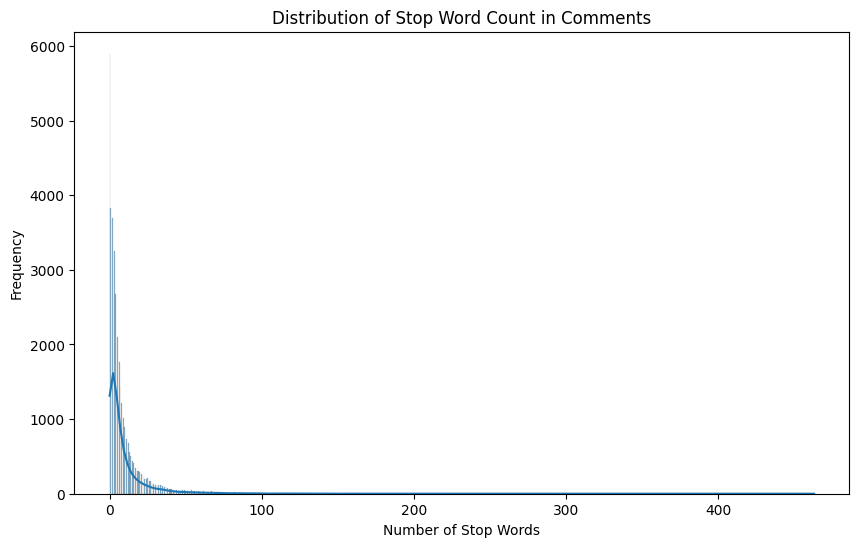

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df["num_of_stop_words"], kde=True)
plt.title("Distribution of Stop Word Count in Comments")
plt.xlabel("Number of Stop Words")
plt.ylabel("Frequency")
plt.show();

This distribution also has a huge right skew, just like the `word_count`.

# Distribution of number of stop words by `category`.

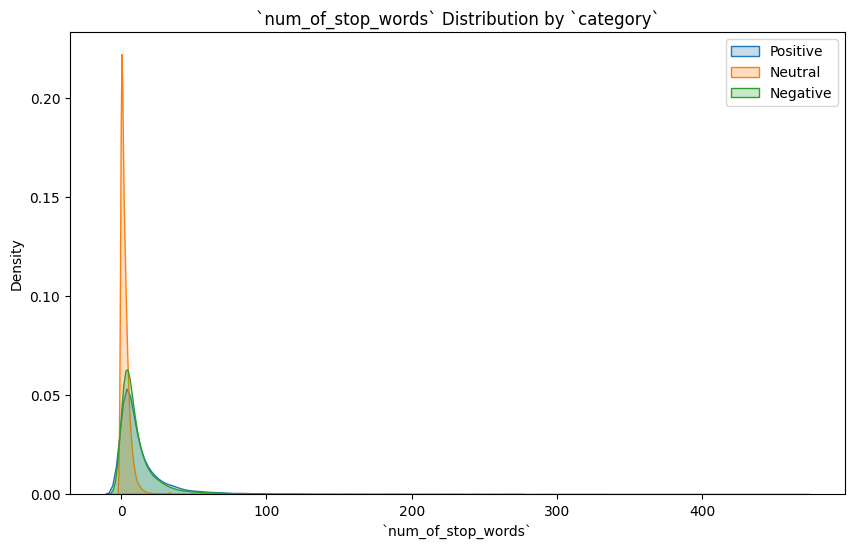

In [37]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df[df["category"] == 1]["num_of_stop_words"], label="Positive", fill=True)
sns.kdeplot(df[df["category"] == 0]["num_of_stop_words"], label="Neutral", fill=True)
sns.kdeplot(df[df["category"] == -1]["num_of_stop_words"], label="Negative", fill=True)

plt.title("`num_of_stop_words` Distribution by `category`")
plt.xlabel("`num_of_stop_words`")
plt.ylabel("Density")
plt.legend()
plt.show();

Again, very similar behavior as `word_count`.

# Bar plot of the median `num_of_stop_words` by `category`

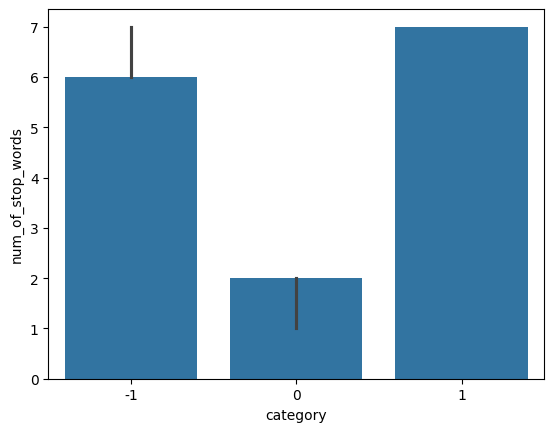

In [38]:
sns.barplot(df, x="category", y="num_of_stop_words", estimator="median")
plt.show();

Again, very similar behavior as `word_count`.

# Top-25 most common stop words

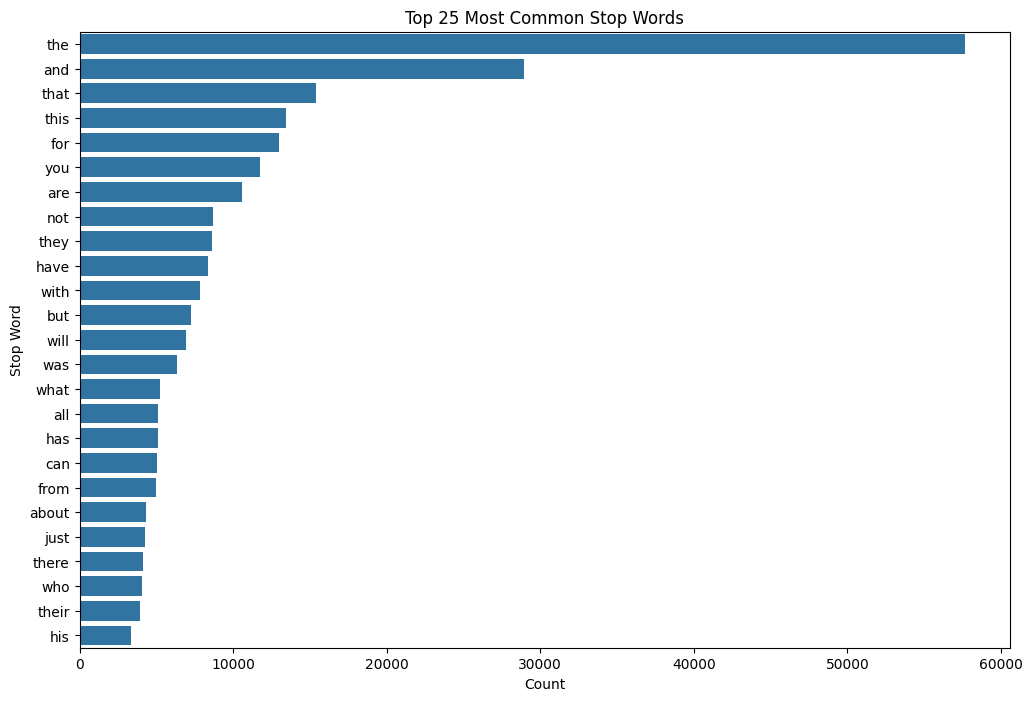

In [39]:
from collections import Counter

all_stop_words = []

for comment in df["clean_comment"]:
    for word in comment.split():
        if word in stop_words:
            all_stop_words.append(word)

most_common_25_stop_words = Counter(all_stop_words).most_common(25)

top_25_stop_words_df = pd.DataFrame(
    most_common_25_stop_words, columns=["stop_word", "count"]
)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_stop_words_df, x="count", y="stop_word")
plt.title("Top 25 Most Common Stop Words")
plt.xlabel("Count")
plt.ylabel("Stop Word")
plt.show();

We can see that the word "not" is used quite a lot in the comments. This word can completely change the sentiment of a sentence. Hence, we will have to tackle this appropriately. The word "but" also has the same effect.

# Number of characters

In [40]:
df["num_chars"] = df["clean_comment"].apply(len)
df.head()

,clean_comment,category,word_count,num_of_stop_words,num_chars
0,family mormon have never tried explain them th...,1,39,13,259
1,buddhism has very much lot compatible with chr...,1,196,59,1268
2,seriously don say thing first all they won get...,-1,86,40,459
3,what you have learned yours and only yours wha...,0,29,15,167
4,for your own benefit you may want read living ...,1,112,45,690


In [41]:
df["num_chars"].describe()

count    36793.000000
mean       181.852798
std        359.702163
min          1.000000
25%         38.000000
50%         80.000000
75%        184.000000
max       8664.000000
Name: num_chars, dtype: float64

Looks similar to the distribution of `word_count`.

# Value count of characters

In [42]:
all_text = " ".join(df["clean_comment"])
char_frequency = Counter(all_text)
char_frequency_df = pd.DataFrame(
    char_frequency.items(),
    columns=["character", "frequency"]
).sort_values(
    by="frequency", ascending=False
)
char_frequency_df

,character,frequency
6,,1091603
12,e,666610
13,t,491287
1,a,481134
3,i,401388
...,...,...
998,丢,1
391,͞,1
996,援,1
995,哭,1


In [43]:
char_frequency_df.tail(50)

,character,frequency
418,ൾ,1
972,挂,1
420,സ,1
969,荷,1
428,ശ,1
429,ൻ,1
966,满,1
964,需,1
433,œ,1
611,症,1


A point of concern are these special characters that are non-English.

# Punctuation characters

In [44]:
df["num_punctuations"] = df["clean_comment"].apply(
    lambda x: sum([1 for char in x if char in '.,!?;:"\'()[]{}-'])
)
df.sample(5)

,clean_comment,category,word_count,num_of_stop_words,num_chars,num_punctuations
13652,please make minute silence for dead chairs,-1,7,1,42,0
12439,this dude right met colleague today who from a...,-1,59,26,320,0
31024,saved always good see breakdown favourite class,1,7,0,47,0
35011,bhai sahab 2010 bol rahe recession raha aur us...,-1,61,3,367,0
14022,lol this looks like prom couple pic modi just ...,1,12,3,60,0


In [45]:
df["num_punctuations"].describe()

count    36793.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: num_punctuations, dtype: float64

Looks like the data does not have any punctuations. Most likely, they are already removed by someone.

# Most common bigrams

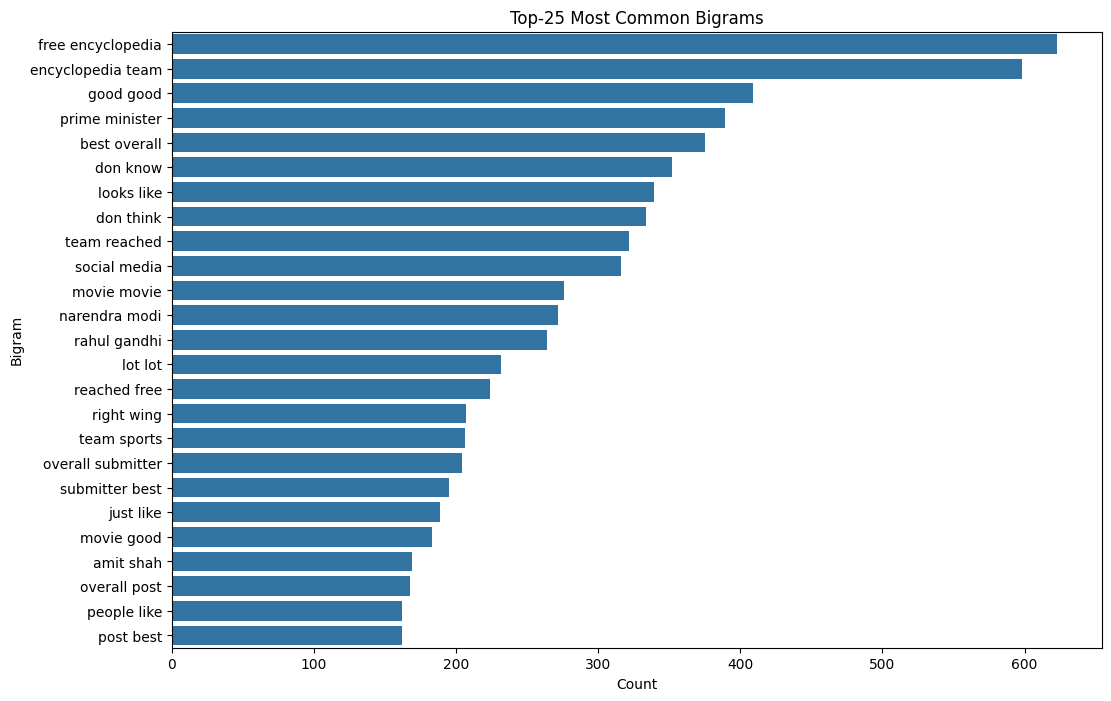

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_25_bigrams = get_top_n_bigrams(corpus=df["clean_comment"], n=25)
top_25_bigrams_df = pd.DataFrame(top_25_bigrams, columns=["bigram", "count"])

plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_bigrams_df, x="count", y="bigram")
plt.title("Top-25 Most Common Bigrams")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.show();

# Most common trigrams

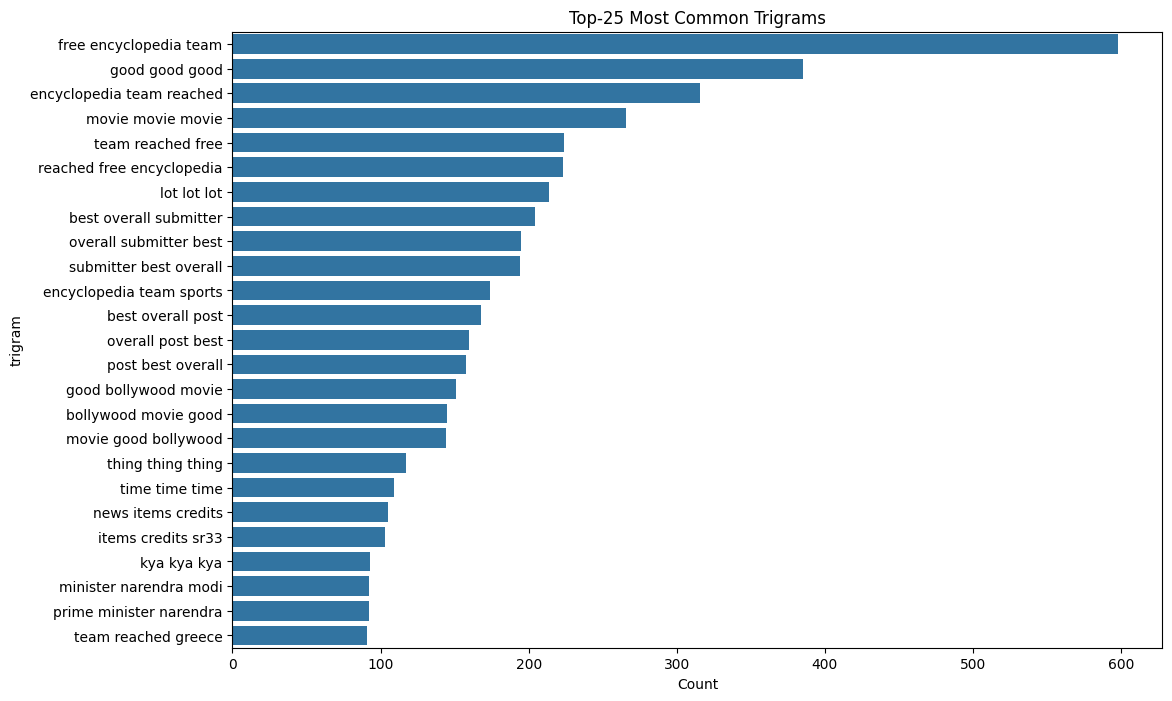

In [47]:
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words="english").fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

top_25_trigrams = get_top_n_trigrams(corpus=df["clean_comment"], n=25)
top_25_trigrams_df = pd.DataFrame(top_25_trigrams, columns=["trigram", "count"])

plt.figure(figsize=(12, 8))
sns.barplot(data=top_25_trigrams_df, x="count", y="trigram")
plt.title("Top-25 Most Common Trigrams")
plt.xlabel("Count")
plt.ylabel("trigram")
plt.show();

# Removing non-English characters

In [48]:
import re

df["clean_comment"] = df["clean_comment"].apply(
    lambda x: re.sub(r"[^A-Za-z0-9\s!?.,]", "", str(x))
)

In [49]:
all_text = " ".join(df["clean_comment"])
char_frequency = Counter(all_text)
char_frequency_df = pd.DataFrame(
    char_frequency.items(),
    columns=["character", "frequency"]
).sort_values(by="frequency", ascending=False)
char_frequency_df

,character,frequency
6,,1091603
12,e,666610
13,t,491287
1,a,481134
3,i,401388
9,n,388465
7,o,379908
17,s,355279
8,r,331425
10,h,296748


In [50]:
df.head()

,clean_comment,category,word_count,num_of_stop_words,num_chars,num_punctuations
0,family mormon have never tried explain them th...,1,39,13,259,0
1,buddhism has very much lot compatible with chr...,1,196,59,1268,0
2,seriously don say thing first all they won get...,-1,86,40,459,0
3,what you have learned yours and only yours wha...,0,29,15,167,0
4,for your own benefit you may want read living ...,1,112,45,690,0


# Removing stopwords

We won't remove the words "not", "but", "however", "no", and "yet", as these words can have an impact on the sentiment of the comment.

In [51]:
stop_words = set(stopwords.words("english")) - {"not", "but", "however", "no", "yet"}
df["clean_comment"] = df["clean_comment"].apply(
    lambda x: " ".join(
        [word for word in x.split() if word.lower() not in stop_words]
    )
)
df.head()

,clean_comment,category,word_count,num_of_stop_words,num_chars,num_punctuations
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


# Lemmatization

In [52]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df["clean_comment"] = df["clean_comment"].apply(
    lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()])
)
df.head()

,clean_comment,category,word_count,num_of_stop_words,num_chars,num_punctuations
0,family mormon never tried explain still stare ...,1,39,13,259,0
1,buddhism much lot compatible christianity espe...,1,196,59,1268,0
2,seriously say thing first get complex explain ...,-1,86,40,459,0
3,learned want teach different focus goal not wr...,0,29,15,167,0
4,benefit may want read living buddha living chr...,1,112,45,690,0


# Word cloud

In [53]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(
        width=800, height=400, background_color="white"
    ).generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show();

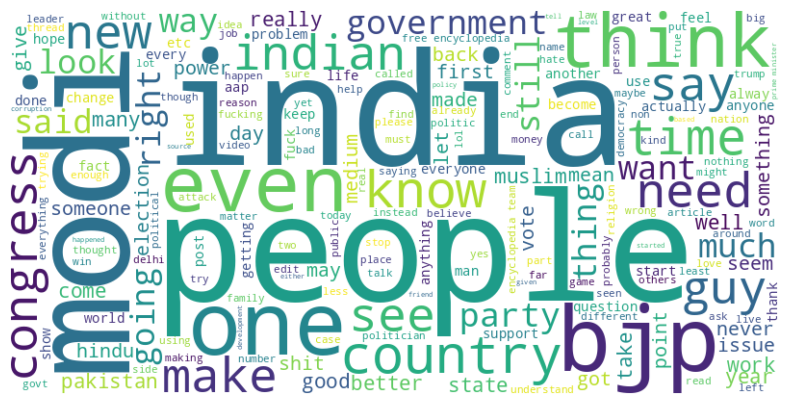

In [54]:
plot_word_cloud(df["clean_comment"])

# Word cloud for positive comments

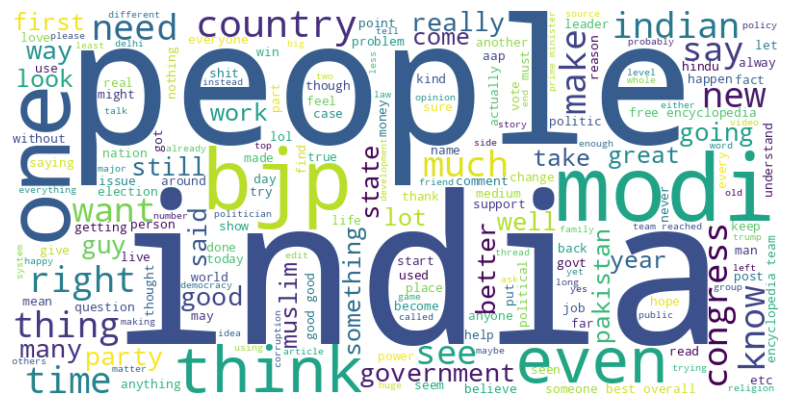

In [55]:
plot_word_cloud(df[df["category"] == 1]["clean_comment"])

# Word cloud for neutral comments

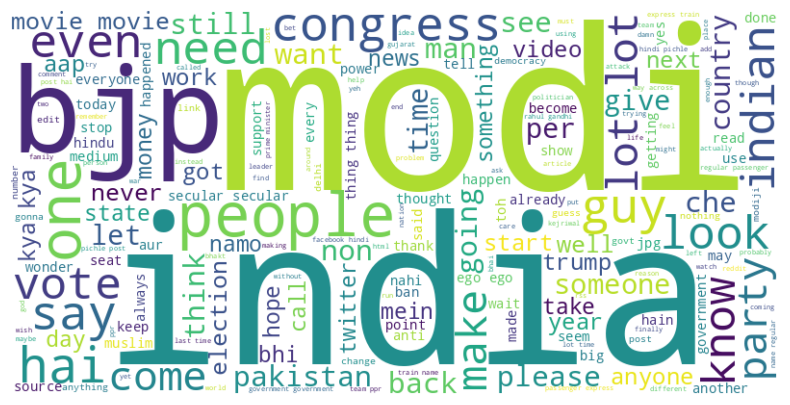

In [56]:
plot_word_cloud(df[df["category"] == 0]["clean_comment"])

# Word cloud for negative comments

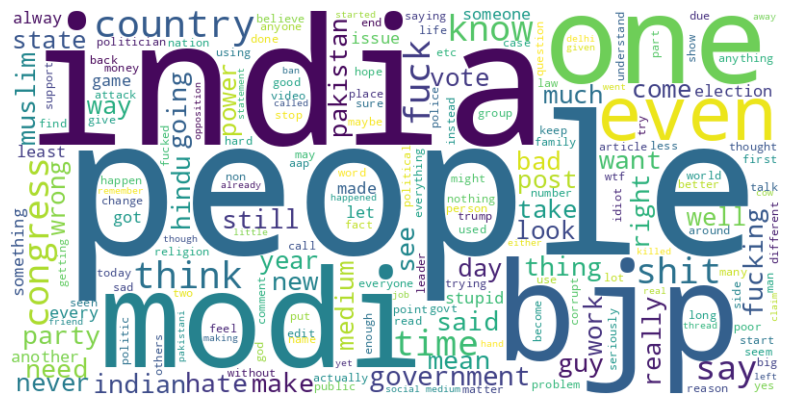

In [57]:
plot_word_cloud(df[df["category"] == -1]["clean_comment"])

# Most frequent words

In [58]:
def plot_top_n_words(df, n):
    words = " ".join(df["clean_comment"]).split()
    counter = Counter(words)
    most_common_words = counter.most_common(n)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10, 7))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top-{n} Most Frequent Words")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show();

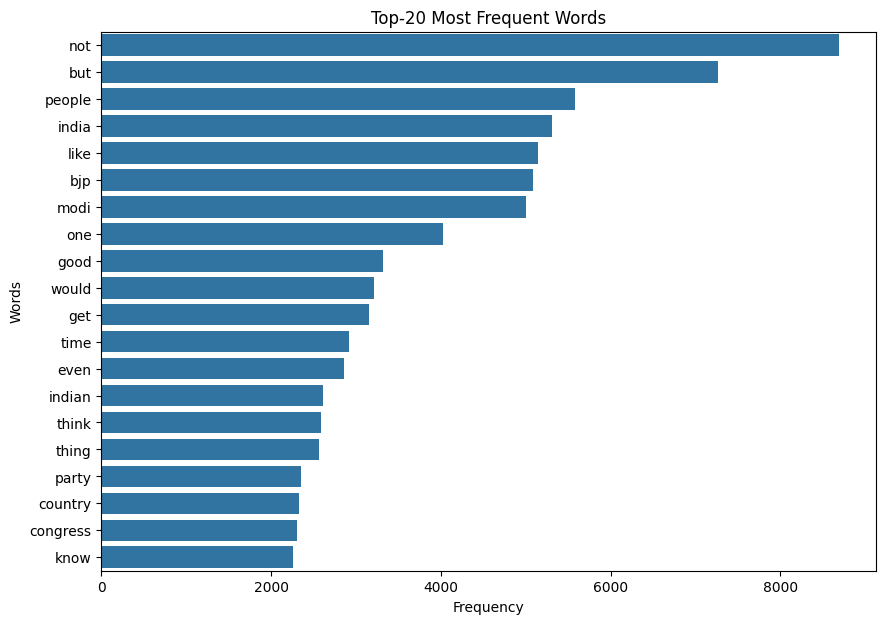

In [59]:
plot_top_n_words(df, n=20)

# Most frequent words by `category`

In [60]:
def plot_top_n_words_by_category(df, n=20, start=0):
    word_category_counts = {}
    for idx, row in df.iterrows():
        words = row["clean_comment"].split()
        category = row["category"]

        for word in words:
            if word not in word_category_counts:
                word_category_counts[word] = {
                    -1: 0,
                    0: 0,
                    1: 0
                }
            word_category_counts[word][category] += 1

    total_word_counts = {
        word: sum(counts.values()) for word, counts in word_category_counts.items()
    }

    most_common_words = sorted(total_word_counts.items(), key=lambda x: x[1], reverse=True)[start: start + n]
    top_words = [word for word, _ in most_common_words]

    word_labels = top_words
    negative_counts = [word_category_counts[word][-1] for word in top_words]
    neutral_counts = [word_category_counts[word][0] for word in top_words]
    positive_counts = [word_category_counts[word][1] for word in top_words]

    plt.figure(figsize=(12, 8))
    bar_width = 0.75

    plt.barh(
        word_labels, negative_counts, color="red", label="Negative (-1)", height=bar_width
    )
    plt.barh(
        word_labels, neutral_counts, left=negative_counts, color="gray", label="Neutral (0)", height=bar_width
    )
    plt.barh(
        word_labels, positive_counts, left=[i + j for i, j in zip(negative_counts, neutral_counts)], color="green", label="Positive (+1)", height=bar_width
    )

    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.title(f"Top-{n} Most Frequent Words with Stacked Sentiment Categories")
    plt.legend(title="Sentiment", loc="lower right")
    plt.gca().invert_yaxis()
    plt.show();

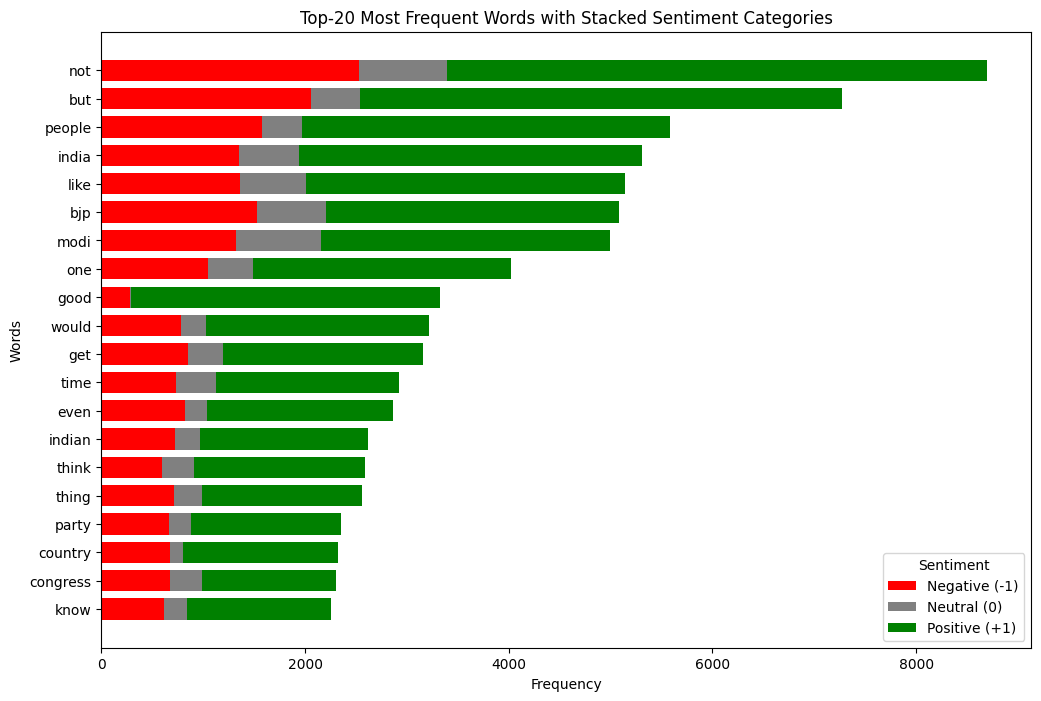

In [61]:
plot_top_n_words_by_category(df, n=20)

Our data seem to contain a lot of political comments. So, our model may perform better on YouTube videos that are political.